In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time as tm
import scipy.constants as cons

In [ ]:
delta_tau = 4e-9 # Mover manualmente 1e-9 o 4e-9
Ef = (cons.h*cons.c)/(1550e-9) # Energía de un fotón de lambda 1500nm
Pot = 431.3e-12
#global mu2
mu1 = 0
mu2 = (Pot*delta_tau)/Ef

In [ ]:
mu2

13.46152974860326

In [ ]:
def paf(n, Q, tau, F): # Probabilidad de afterpulsing
  return (Q/tau)*np.exp(-n/(F*tau))

def model(F, mu, Param):
    # Param: Probabilidad de cuentas oscuras (PDC), Q, tau, Eficiencia detector
    Tol1, Tol2 = 1e-9, 1e-4
    Pph0 = np.exp(-mu*Param[3])
    Ps = 1 - (1 - Param[0])*Pph0 # Probabilidad 1era compuerta
    PC=Ps;
    while True:
        prod = 1
        j = 1
        while True:
            PAF = paf(j, Param[1], Param[2], F)
            if PAF*PC <= Tol1:
                break
            else:
                prod *= (1 - PC*PAF)
                j=j+1
        PC1= 1 - (1 - Ps)*prod;  # habia puesto PC en lugar de Param[0]
        if np.absolute((PC1 - PC)/PC) < Tol2:
            break
        else:
            PC=PC1
    return PC

In [ ]:
def NLLeastSquares(x, y, mu, C0, Optlist):
    DataLength = len(x)
    NumParam = len(Optlist)
    Tol = 1e-4

    #while True:
    for sp in range(1):
        CR=C0[Optlist]
        beta = 0
        Z = np.zeros(DataLength)
        X = np.zeros((DataLength, NumParam))
        for i in range(len(Z)):
            Z[i] = y[i] - model(x[i], mu, C0)
        h = 1e-6
        DeltaC = np.zeros( NumParam )
        for i in range( DataLength ):
            k=0;
            for j in Optlist:
                DeltaC = np.copy(C0)
                DeltaC[j] += DeltaC[j]*h
                X[i,k] = ( model(x[i], mu, DeltaC) - model(x[i], mu,C0) )/(C0[j]*h)
                k+=1

        beta = np.linalg.inv(X.T@X)@X.T@Z
        if (Tol < np.max( np.abs( beta/CR ) )) and (np.sum((CR+beta) <=0) == 0) :
            k=0;
            for j in Optlist:
                C0[j] += beta[k]
                k=+1
            display(C0)
        else:
            break
    return C0

In [ ]:
def ENJminS2(x, y, mu, C0):
  N1=20 #numero de particulas
  N=N1+1
  DataLength = len(x)
  NumParam = len(C0)
  Tol = 1e-7
  Po=2;
  Pot=Po*(np.random.rand(N1, NumParam)-0.5)
  PP=np.zeros([N,NumParam])


  PP[0,:]=C0.T
  for n in range(N1):
      PP[n+1,:]=C0.T*10**Pot[n,:]


  S2=np.zeros(N);
  # Nota 1 esta parte la habia borrado
  for k in range(N):
      for j in range(DataLength):
          S2[k]+=(y[j]-model(x[j], mu, PP[k,:]))**2

  #       en lugar de hacer un copy-paste para generar la parte de abajo
  for r in range(20):
    for k in range(N):
      NewPar=np.zeros(NumParam)
      for n in range(NumParam):
          NewPar[n]=PP[k,n]*10**(np.random.rand()-0.5)
      S2p = 0
      for j in range(DataLength):
          S2p+=(y[j]-model(x[j], mu, NewPar))**2
      if S2p<S2[k]:
          for n in range(NumParam):
              PP[k,n]=NewPar[n]
          S2[k]=S2p


  C0=PP[np.argmin(S2),:]

  return C0

In [ ]:
data = np.genfromtxt('n3E10W2_5.txt')

In [ ]:
x = data[:,1]
y = data[:,3]/data[:,1]

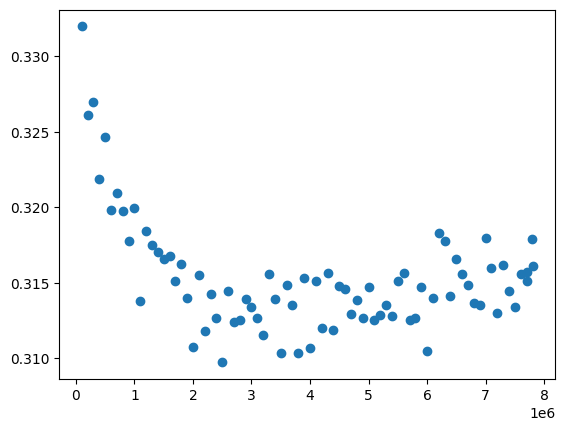

In [ ]:
plt.scatter(x, y)
plt.show()

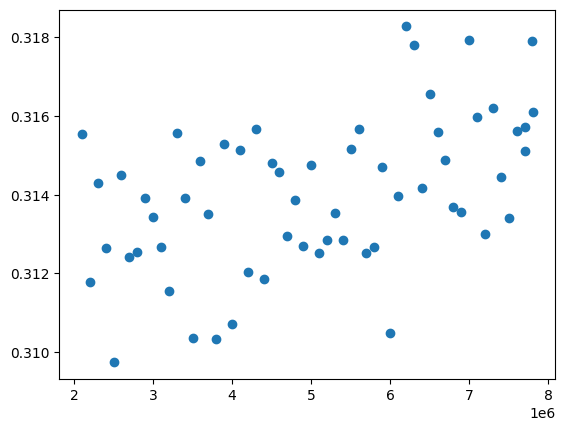

In [ ]:
x, y = x[20:], y[20:]
plt.scatter(x, y)
plt.show()

In [ ]:
u=y<=0.6
x=x[u]
y=y[u]
Q0=1/x[y==y.max()]
Q0=np.min(np.array([1e-7,Q0[0]]))
InitParams = np.array([y[0], Q0, 10*Q0, 0.1])

t1=tm.time()
FitParams = ENJminS2(x, y, mu2, InitParams)
FitParams = NLLeastSquares(x, y, mu2, FitParams, range(4))
FitParams = NLLeastSquares(x, y, mu2, FitParams, [0, 1])
FitParams = NLLeastSquares(x, y, mu2, FitParams, [0, 2])
FitParams = NLLeastSquares(x, y, mu2, FitParams, [0, 3])
FitParams = NLLeastSquares(x, y, mu2, FitParams, [1, 2])
FitParams = NLLeastSquares(x, y, mu2, FitParams, [1, 3])
FitParams = NLLeastSquares(x, y, mu2, FitParams, [2, 3])
FitParams = NLLeastSquares(x, y, mu2, FitParams, range(4))
t2=tm.time()
print(t2-t1)
np.savetxt('n3E10W2_5_FIT.txt', FitParams)
FitParams

array([3.04588852e-02, 2.89888773e-09, 4.99578313e-07, 2.54358456e-02])

array([3.04588852e-02, 2.48255635e-09, 7.23440622e-07, 2.54358456e-02])

array([3.04588852e-02, 2.45226554e-09, 7.23440622e-07, 2.54499808e-02])

122.85223579406738


array([3.04588852e-02, 2.45226554e-09, 7.23440622e-07, 2.54499808e-02])

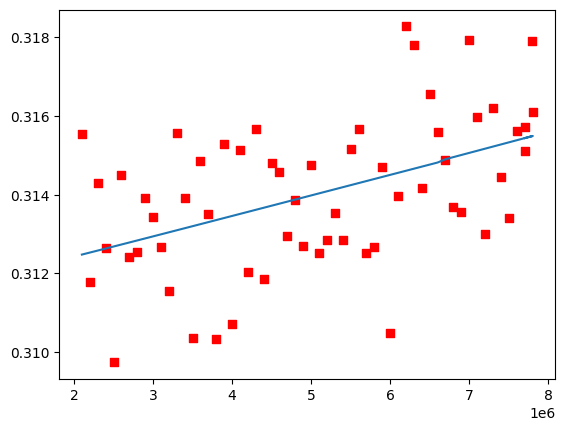

In [ ]:
X, Y = x, np.zeros(int(len(x)))
for k in range(len(Y)):
    Y[k] = model(X[k], mu2, FitParams)
plt.scatter(x, y, marker='s', color='red')
plt.plot(X, Y)
plt.show()